In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
import random

In [2]:
x1 = x2 = np.arange(-15, 15, 0.1)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]

In [3]:
class NormalDistribution:
    def __init__(self, mu, sigma):
        assert np.array_equal(sigma, sigma.T)
        self._mu = mu
        self._sigma = sigma

        self._inv_sigma = np.linalg.inv(sigma)

    def calc_prob(self, X):
        return multivariate_normal.pdf(X, mean=self._mu, cov=self._sigma)

    def sample(self, N):
        return np.random.multivariate_normal(self._mu, self._sigma, N)

    def calc_score(self, X):
        return -1.0 * (
            np.broadcast_to(
                self._inv_sigma.reshape(1, X.shape[1], X.shape[1]),
                (X.shape[0], X.shape[1], X.shape[1]),
            )
            @ (X - self._mu).reshape(X.shape[0], X.shape[1], 1)
        ).reshape(X.shape[0], X.shape[1])


class ContaminatedNormalDistribution:
    def __init__(self, dist_params_list):
        sum_ratio = sum([ratio for _, _, ratio in dist_params_list])
        epsilon = 0.0001
        assert 1.0 - epsilon < sum_ratio < 1.0 + epsilon
        mu0, sigma0, _ = dist_params_list[0]
        self._dist_list = []
        self._ratio_list = []
        for mu, sigma, ratio in dist_params_list:
            assert mu0.shape == mu.shape
            assert sigma0.shape == sigma.shape
            dist = NormalDistribution(mu, sigma)
            self._dist_list.append(dist)
            self._ratio_list.append(ratio)

    def calc_prob(self, X):
        prob = np.zeros(X.shape[0])
        prob_list = []
        for i, dist in enumerate(self._dist_list):
            ratio = self._ratio_list[i]
            tmp_prob = dist.calc_prob(X)
            prob += ratio * tmp_prob
            prob_list.append(tmp_prob)
        return prob, prob_list

    def sample(self, N):
        dist_indexes = np.random.choice(
            len(self._ratio_list), N, p=[ratio for ratio in self._ratio_list]
        )
        tmp_N_list = [
            np.count_nonzero(dist_indexes == i) for i in range(len(self._ratio_list))
        ]
        samples = []  # np.zeros((N, self._dist_params_list[0][0].shape[0]))
        for i, tmp_N in enumerate(tmp_N_list):
            samples.append(self._dist_list[i].sample(tmp_N))
        random.shuffle(samples)
        samples = np.concatenate(samples, axis=0)
        return samples

    def calc_score(self, X):
        # epsilon = 10e-10
        epsilon = np.finfo(np.float32).tiny
        score = np.zeros((X.shape[0], X.shape[1]))
        prob, prob_list = self.calc_prob(X)
        for i, dist in enumerate(self._dist_list):
            ratio = self._ratio_list[i]
            score += (
                ratio
                * dist.calc_score(X)
                * (
                    np.broadcast_to(
                        prob_list[i].reshape(X.shape[0], 1), (X.shape[0], X.shape[1])
                    )
                    + epsilon
                )
            )
        score /= (
            np.broadcast_to(prob.reshape(X.shape[0], 1), (X.shape[0], X.shape[1]))
            + epsilon
        )
        return score

In [4]:
dist_params_list = []

mu = np.array([-10.0, 10.0])
sigma = np.array([[0.5, 0], [0, 0.5]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

mu = np.array([0.0, -7.5])
sigma = np.array([[0.5, 0], [0, 0.5]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

mu = np.array([10.0, 10.0])
sigma = np.array([[0.5, 0], [0, 0.5]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

mu = np.array([0.0, 2.5])
sigma = np.array([[1.25, 0], [0, 1.25]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

mu = np.array([-6.0, -2.5])
sigma = np.array([[2, 1.5], [1.5, 2]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

mu = np.array([2.5, -2.5])
sigma = np.array([[2, 1.5], [1.5, 2]])
ratio = 1 / 6
dist_params_list.append((mu, sigma, ratio))

prob, _ = ContaminatedNormalDistribution(dist_params_list).calc_prob(X)
prob = prob.reshape(X1.shape)

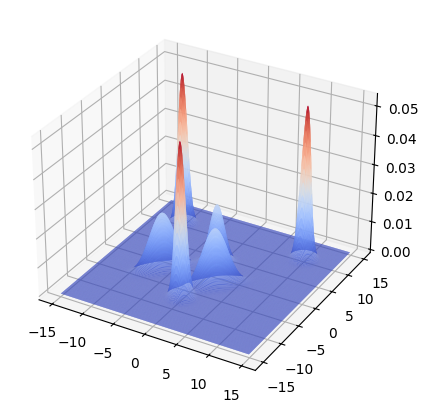

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X1, X2, prob, rstride=1, cstride=1, cmap=cm.coolwarm)
fig.savefig("../docs/figure/contaminated_normal_distribution.png")

In [6]:
sampled_X = ContaminatedNormalDistribution(dist_params_list).sample(10000)

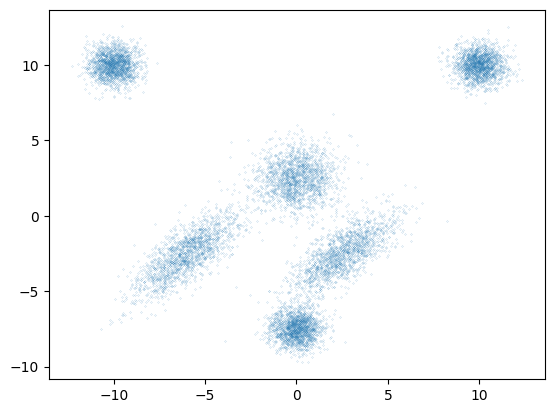

In [7]:
plt.scatter(sampled_X[:, 0], sampled_X[:, 1], s=0.01)
plt.savefig("../docs/figure/contaminated_normal_distribution_sample.png")

In [8]:
def metropolis_hastings1(dist_params_list, N, burn_in=1000):
    dim = 2
    x = np.zeros((1, dim))
    samples = []
    for i in range(N + burn_in):
        x_candidate = x + np.random.normal(0, 1, (1, dim))
        acceptance_rate = min(
            1,
            ContaminatedNormalDistribution(dist_params_list).calc_prob(x_candidate)[0]
            / ContaminatedNormalDistribution(dist_params_list).calc_prob(x)[0],
        )
        if np.random.rand() < acceptance_rate:
            x = x_candidate
        if i >= burn_in:
            samples.append(x[0])
    return np.array(samples)


# def metropolis_hastings2(dist_params_list, N, iter=1000):
#     dim = 2
#     samples = []
#     p = ContaminatedNormalDistribution(dist_params_list)
#     for i in range(N):
#         x = np.random.normal(0, 1, (1, dim))
#         noise = np.random.normal(0, 1, (iter, dim))
#         rands = np.random.rand(iter)
#         x_prob = p.calc_prob(x)
#         for j in range(iter):
#             x_candidate = x + noise[j]
#             acceptance_rate = min(1, p.calc_prob(x_candidate) / p.calc_prob(x))
#             if rands[j] < acceptance_rate:
#                 x = x_candidate
#                 x_prob = p.calc_prob(x)
#         samples.append(x)
#     return np.array(samples)


def metropolis_hastings2(dist_params_list, N, iter=1000):
    dim = 2
    samples = []
    p = ContaminatedNormalDistribution(dist_params_list)
    X = np.random.normal(0, 1, (N, dim))
    # X = np.zeros((N, dim))
    # X = np.ones((N, dim))
    # X[:, 0] *= 100.0
    # X[:, 1] *= -100.0
    X_prob = p.calc_prob(X)
    epsilon = np.finfo(np.float32).tiny
    for j in range(iter):
        noise = np.random.normal(0, 1, (N, dim))
        X_candidate = X + noise
        X_prob = p.calc_prob(X)[0] + epsilon
        X_candidate_prob = p.calc_prob(X_candidate)[0] + epsilon
        acceptance_rate = np.minimum(1, X_candidate_prob * (1 / X_prob))
        rand = np.random.rand(N)
        X[rand < acceptance_rate] = X_candidate[rand < acceptance_rate]
    return X

In [9]:
mh1_sampled_X = metropolis_hastings1(dist_params_list, 10000)

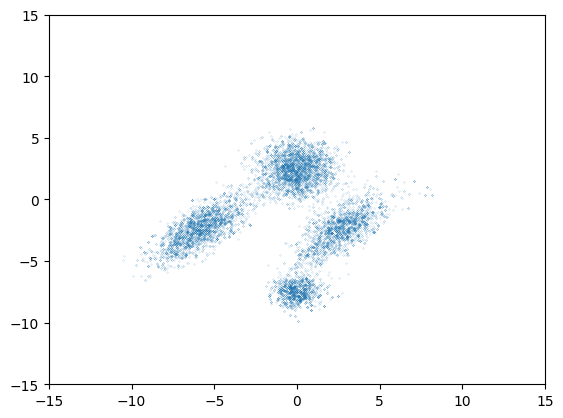

In [10]:
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
plt.scatter(mh1_sampled_X[:, 0], mh1_sampled_X[:, 1], s=0.01)

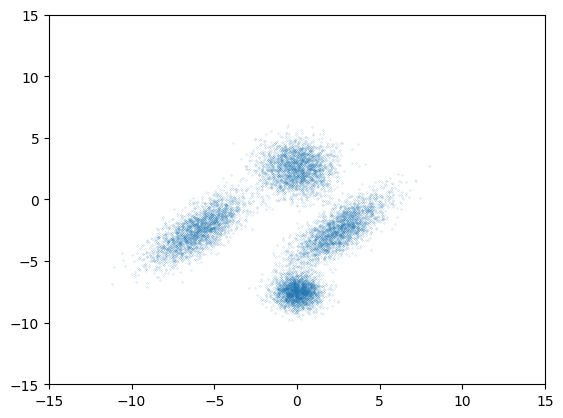

In [11]:
mh2_sampled_X = metropolis_hastings2(dist_params_list, 10000)
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
plt.scatter(mh2_sampled_X[:, 0], mh2_sampled_X[:, 1], s=0.01)

In [12]:
def metropolis_hastings(dist_params_list, X0, N, iter=1000):
    dim = 2
    p = ContaminatedNormalDistribution(dist_params_list)
    X = X0
    X_prob = p.calc_prob(X)
    epsilon = np.finfo(np.float32).tiny
    for j in range(iter):
        noise = np.random.normal(0, 1, (N, dim))
        X_candidate = X + noise
        X_prob = p.calc_prob(X)[0] + epsilon
        X_candidate_prob = p.calc_prob(X_candidate)[0] + epsilon
        acceptance_rate = np.minimum(1, X_candidate_prob * (1 / X_prob))
        rand = np.random.rand(N)
        X[rand < acceptance_rate] = X_candidate[rand < acceptance_rate]
    return X


X0 = np.random.normal(0, 1, (10000, 2))
mh_sampled_X_snd_x0 = metropolis_hastings(dist_params_list, X0, 10000)

X0 = np.ones((10000, 2))
X0[:, 0] = 100.0
X0[:, 1] = -100.0
mh_sampled_X_far_x0 = metropolis_hastings(dist_params_list, X0, 10000)

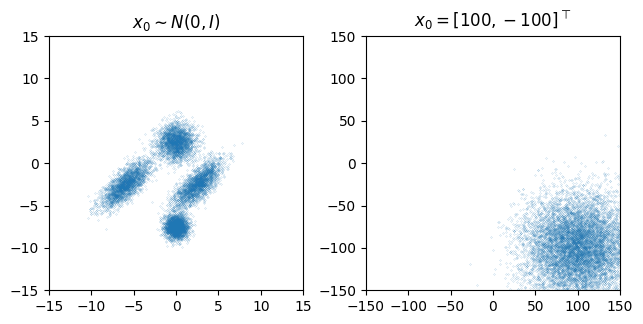

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(-15.0, 15.0)
ax1.set_ylim(-15.0, 15.0)
ax2.set_xlim(-150.0, 150.0)
ax2.set_ylim(-150.0, 150.0)
ax1.set_aspect("equal", adjustable="box")
ax2.set_aspect("equal", adjustable="box")
ax1.title.set_text(r"$x_0 \sim N(0, I)$")
ax2.title.set_text(r"$x_0 = [100, -100]^\top$")
ax1.scatter(mh_sampled_X_snd_x0[:, 0], mh_sampled_X_snd_x0[:, 1], s=0.01)
ax2.scatter(mh_sampled_X_far_x0[:, 0], mh_sampled_X_far_x0[:, 1], s=0.01)
fig.tight_layout()
plt.show()
# plt.savefig("../docs/figure/mh_sample.png")

In [14]:
dist1 = NormalDistribution(dist_params_list[5][0], dist_params_list[5][1])
a = np.broadcast_to(
    dist1._inv_sigma.reshape(1, X.shape[1], X.shape[1]),
    (X.shape[0], X.shape[1], X.shape[1]),
) @ (X - dist1._mu).reshape(X.shape[0], X.shape[1], 1)
# a = np.broadcast_to(dist1._inv_sigma.reshape(1, X.shape[1], X.shape[1]), (X.shape[0], X.shape[1], X.shape[1])) @ (X - dist1._mu).reshape(X.shape[0], X.shape[1], 1).reshape(X.shape[0], X.shape[1])

In [15]:
dist1._inv_sigma @ (X[1] - dist1._mu)

array([-9.17142857,  0.62857143])

In [16]:
def langevin_monte_carlo(dist_params_list, N, K=1000, alpha=0.1):
    dim = 2
    p = ContaminatedNormalDistribution(dist_params_list)
    noise_coeef = np.sqrt(2 * alpha)
    # X = np.random.normal(0, 1, (N, dim))
    X = np.ones((N, dim))
    X[:, 0] *= 100.0
    X[:, 1] *= -100.0
    noise = np.random.normal(0, 1, (K, N, dim))
    for j in range(K):
        X = X + alpha * p.calc_score(X) + noise_coeef * noise[j]
    return X

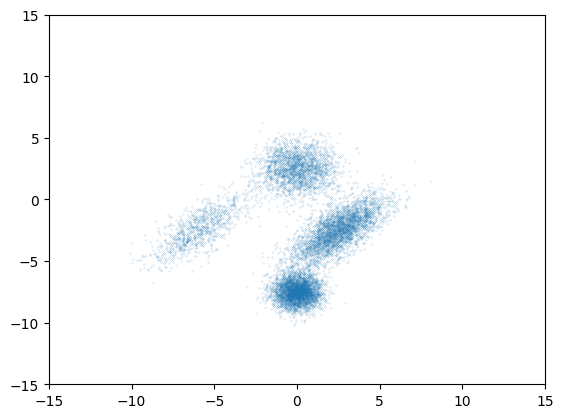

In [17]:
lm_sampled_X = langevin_monte_carlo(dist_params_list, 10000)
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
plt.scatter(lm_sampled_X[:, 0], lm_sampled_X[:, 1], s=0.01)

In [18]:
def langevin_monte_carlo(dist_params_list, X0, N, K=1000, alpha=0.1):
    dim = 2
    X = X0
    p = ContaminatedNormalDistribution(dist_params_list)
    noise_coeef = np.sqrt(2 * alpha)

    noise = np.random.normal(0, 1, (K, N, dim))
    for j in range(K):
        X = X + alpha * p.calc_score(X) + noise_coeef * noise[j]
    return X


X0 = np.random.normal(0, 1, (10000, 2))
lm_sampled_X_snd_x0 = langevin_monte_carlo(dist_params_list, X0, 10000)

X0 = np.ones((10000, 2))
X0[:, 0] = 100.0
X0[:, 1] = -100.0
lm_sampled_X_far_x0 = langevin_monte_carlo(dist_params_list, X0, 10000)

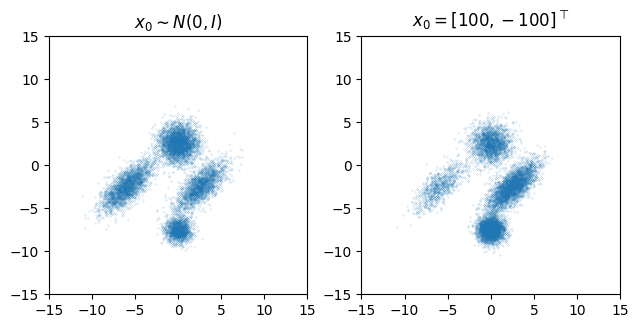

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim(-15.0, 15.0)
ax1.set_ylim(-15.0, 15.0)
ax2.set_xlim(-15.0, 15.0)
ax2.set_ylim(-15.0, 15.0)
ax1.set_aspect("equal", adjustable="box")
ax2.set_aspect("equal", adjustable="box")
ax1.title.set_text(r"$x_0 \sim N(0, I)$")
ax2.title.set_text(r"$x_0 = [100, -100]^\top$")
ax1.scatter(lm_sampled_X_snd_x0[:, 0], lm_sampled_X_snd_x0[:, 1], s=0.01)
ax2.scatter(lm_sampled_X_far_x0[:, 0], lm_sampled_X_far_x0[:, 1], s=0.01)
fig.tight_layout()
plt.show()
# plt.savefig("../docs/figure/lm_sample.png")

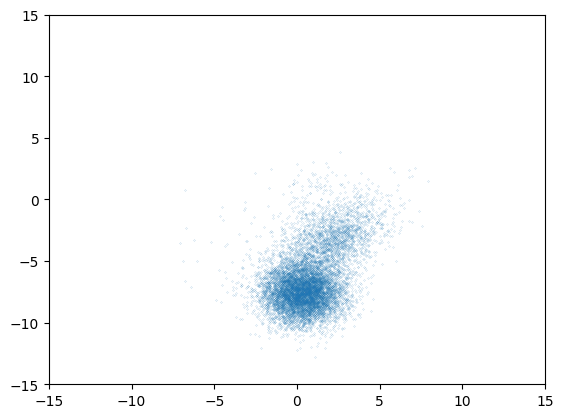

In [20]:
dsm_sampled_X = np.loadtxt("../data/dsm_sampled_X.far_x0.numpy.txt")
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
plt.scatter(dsm_sampled_X[:, 0], dsm_sampled_X[:, 1], s=0.01)
# plt.savefig('../docs/figure/dsm_sample.png')

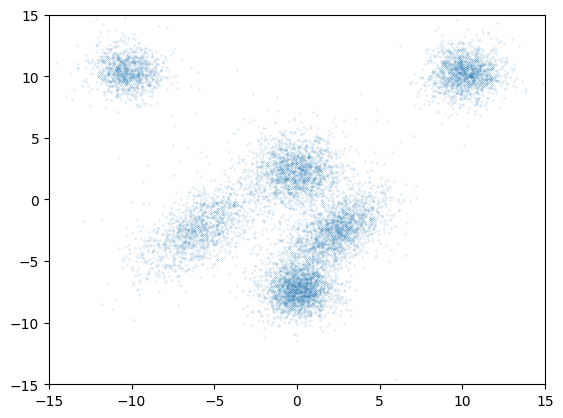

In [21]:
sbm_sampled_X = np.loadtxt("../data/sbm_sampled_X.numpy.txt")
plt.xlim(-15.0, 15.0)
plt.ylim(-15.0, 15.0)
plt.scatter(sbm_sampled_X[:, 0], sbm_sampled_X[:, 1], s=0.01)
# plt.savefig("../docs/figure/sbm_sample.png")

In [22]:
far_X = np.array([[7.5, 7.5]])
ContaminatedNormalDistribution(dist_params_list).calc_score(far_X)

array([[4.99999991, 4.99999951]])